In [1]:
import os

# Change current working directory
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [8]:
from matplotlib import rc, font_manager
import warnings
import matplotlib.pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family'] = 'Malgun Gothic'
warnings.simplefilter(action='ignore', category=FutureWarning)

1/1 [==============================] - 0s 241ms/step


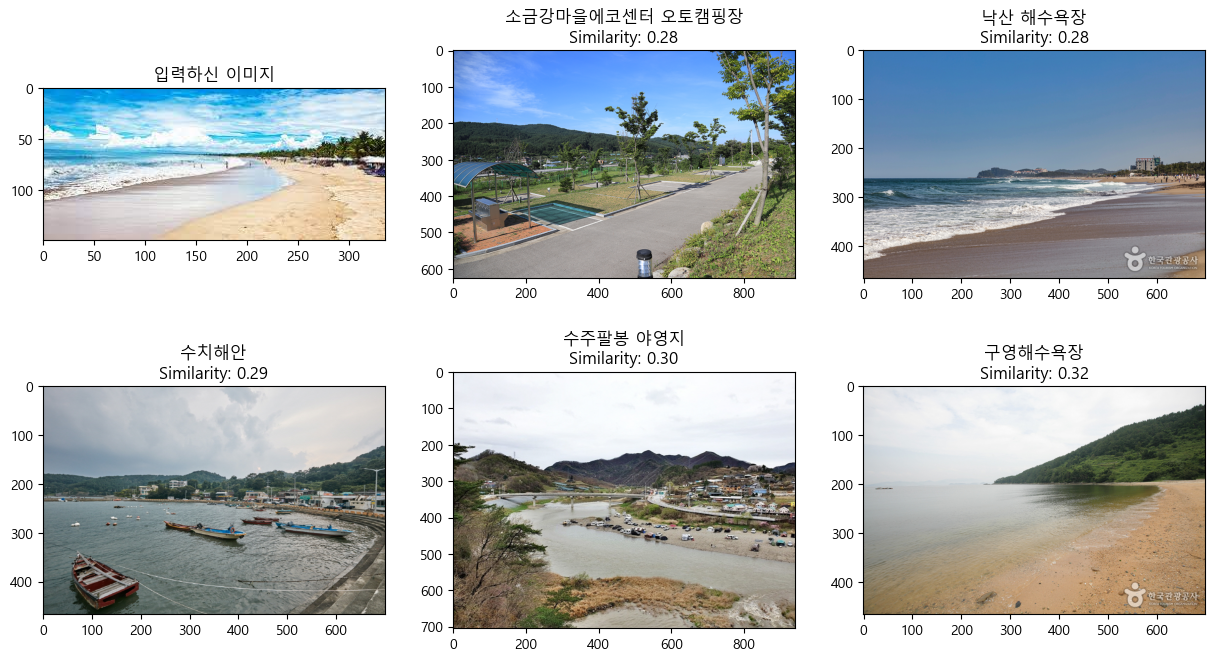

In [9]:
import numpy as np
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import matplotlib.font_manager as fm
import unicodedata

# plt.rcParams["font.family"] = "NanumGothic"

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

# Function to extract features from an image
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features

test_images = ['해변.jpg']
# test_images = ['test.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg']
result_list = []

for test_image in test_images:
    input_image_path = test_image
    input_features = extract_features(input_image_path, model)
    dataset_path = './TourAPI 이미지'

    similarities = []
    images = []

    # Loop through the images in the dataset folder
    for filename in os.listdir(dataset_path):
        if any(filename.lower().endswith(ext) for ext in ['.jpg', '.png', '.jpeg', '.bmp']):
            image_path = os.path.join(dataset_path, filename)
            images.append(image_path)
            features = extract_features(image_path, model)
            similarity = cosine_similarity([input_features], [features])
            similarities.append(similarity[0][0])

    # Find the top 5 most visually similar images
    similar_indices = np.argsort(similarities)[-6:-1]  # Change to [-4:] for top 4
    similar_images = [images[i] for i in similar_indices]

    # Read the 'tourapi_data.csv' file into a DataFrame
    df = pd.read_csv('tourapi_data.csv', encoding='utf-8-sig')

    # Loop through the images in the dataset folder
    for similar_image in similar_images:
        similar_image_name = os.path.splitext(os.path.basename(similar_image))[0]
        similar_image_name = unicodedata.normalize('NFC', similar_image_name)
        for index, row in df.iterrows():
            file_name_normalized = row['명칭']
            file_name_normalized = unicodedata.normalize('NFC', file_name_normalized)
            if similar_image_name == file_name_normalized:
                result_list.append([row['명칭'], row['주소']])

    # Display the input image
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 3, 1)
    plt.title('입력하신 이미지')  # Change title for the input image
    img = image.load_img(input_image_path)
    plt.imshow(img)

    # Display the most visually similar images
    for i, similar_image in enumerate(similar_images):
        plt.subplot(2, 3, i + 2)
        similar_img = image.load_img(similar_image)
        similar_image_name = os.path.splitext(os.path.basename(similar_image))[0]
        similar_image_name = unicodedata.normalize('NFC', similar_image_name)
        plt.title(f"{similar_image_name}\nSimilarity: {similarities[similar_indices[i]]:.2f}")
        plt.imshow(similar_img)

    # Save the figure before calling plt.show()
    output_directory = './output_images/'  # Directory to save the output images

    # Check if the directory exists, if not, create it
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Save the figure in the output directory with a valid path
    output_image_name = '.'.join(test_image.split('.')[:-1])  # Extract the output image name without the extension
    plt.savefig(os.path.join(output_directory, output_image_name + '_output.jpg'))

    # Concatenate the extracted data into a DataFrame outside the loop
    if result_list:
        result_list = pd.DataFrame(result_list, columns=['명칭', '주소'])